In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060 SUPER'

In [2]:
import torch
print(torch.__version__)

1.11.0


In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import models as model

## 1. Data loading

### 1.1 load dataset

In [4]:
# load dataset
# for reproducibility set seed
torch.manual_seed(0)
np.random.seed(0)
# load training data information
train_df = pd.read_csv('COVIDxCXR-2/train.txt',sep=" ",header=None)

# add column name
train_df.columns = ['patient_id','filename','class','data_source']

# only filename and class are needed for image classification
# drop unnecessary columns
train_df = train_df.drop(['patient_id','data_source'], axis=1)

# same for test set
test_df = pd.read_csv('COVIDxCXR-2/test.txt',sep=" ",header=None)
test_df.columns = ['patient_id','filename','class','data_source']
test_df = test_df.drop(['patient_id','data_source'], axis=1)

# get negative values in class column
negative = train_df[train_df['class'] == 'negative']

# get positive values in class column
positive = train_df[train_df['class'] == 'positive']

from sklearn.utils import resample
# we downsample each class to 13990 samples
df_negative_downsampled = resample(negative, replace=True,random_state=0, n_samples = 13990)
df_positive_downsampled = resample(positive, replace=True,random_state=0, n_samples = 13990)

# concatenate
train_df = pd.concat([df_negative_downsampled,df_positive_downsampled])

from sklearn.utils import shuffle
# shuffle the dataset again to randomize it
train_df = shuffle(train_df,random_state=0)

# encode the label to numbers
train_df['class'] = train_df['class'].map({'negative': 0, 'positive': 1})
test_df['class'] = test_df['class'].map({'negative': 0, 'positive': 1})

In [5]:
# split the train data into training and validation dataset
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)

In [6]:
#Let's see how many images for training and validation and testing

print(f"Negative and positive values of train: {train_df['class'].value_counts()}")
print(f"Negative and positive values of validation: {valid_df['class'].value_counts()}")
print(f"Negative and positive values of test: {test_df['class'].value_counts()}")

Negative and positive values of train: 1    12623
0    12559
Name: class, dtype: int64
Negative and positive values of validation: 0    1431
1    1367
Name: class, dtype: int64
Negative and positive values of test: 1    200
0    200
Name: class, dtype: int64


In [7]:
# define directory path
train_path = 'COVIDxCXR-2/train'
test_path = 'COVIDxCXR-2/test'

# define function inherited from Dataset class to get data with indices
from torch.utils.data import Dataset
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms
from PIL import Image
class CustomImageDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx,0])

        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.data_frame.iloc[idx,-1]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
training_data = CustomImageDataset(
    data_frame=train_df,
    root_dir=train_path,
    transform=transforms.Compose([
        
        transforms.Resize([224,224],transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


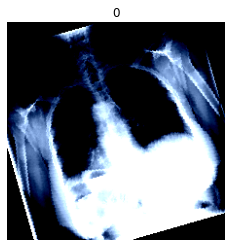

In [9]:
# show sample images
temp_img, temp_label = training_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

In [10]:
validation_data = CustomImageDataset(
    data_frame=valid_df,
    root_dir=train_path,
    transform=transforms.Compose([
        transforms.Resize([224,224],transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

test_data  = CustomImageDataset(
    data_frame=test_df,
    root_dir=test_path,
    transform=transforms.Compose([
        transforms.Resize([224,244],transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


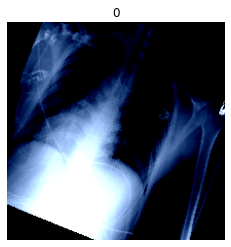

In [11]:
temp_img, temp_label = validation_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


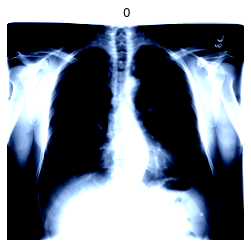

In [12]:
temp_img, temp_label = test_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

### 1.2 Split dataset

In [13]:
from torch.utils.data import DataLoader
import copy

In [14]:

def covid_iid(dataset, num_users):
    # local dataset num
    num_items = int(len(dataset)/num_users)
    # dict_users -> 所有客户端数据samples的索引字典，all_idxs -> 所有数据samples的索引列表
    dict_users, all_idxs = {},[i for i in range(len(dataset))]
    # 基于clients num执行循环，分配样本
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    
    return dict_users



In [15]:
class DatasetSplit(Dataset):
    def __init__(self, dataset,idxs):
        self.dataset = dataset
        self.idxs = list(idxs)
    
    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self,item):
        image,label = self.dataset[self.idxs[item]]
        return image, label
    
class LocalUpdate(object):
    def __init__(self, dataset=None, idxs=None, batch_size=10, local_epoch=10):
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs),batch_size,shuffle=True)
        self.local_epoch = local_epoch
    
    def train(self, net):
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
        
        epoch_loss = []
        
        for iter in range(self.local_epoch):
            batch_loss = []
            for batch_idx, (images,labels) in enumerate(self.ldr_train):
                images = images.to(device)
                labels = labels.to(device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss)/len(epoch_loss)

In [23]:
def test_acc(model,dataset):
    loader = DataLoader(dataset,batch_size=64,shuffle=True,num_workers=0)
    num_correct = 0
    num_samples = 0
    model.eval()
    model.cuda()
    
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _,predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
        
    model.train()

In [17]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k],len(w))
    return w_avg

In [18]:
net_glob = model.mobilenet_v3_small()
net_glob.train()
# copy weights
# init global model weight
w_glob = net_glob.state_dict()

# training
loss_train = []
cv_loss,cv_acc = [],[]
val_loss_pre, counter = 0,0
net_best = None
best_loss = None
val_acc_list, net_list = [],[]
epochs = 50
total_num_users = 10
frac = 0.4

In [19]:
dict_users = covid_iid(training_data, total_num_users)
for iter in range(epochs):
    loss_locals = []
    
    w_locals = []
    
    max_users_per_training = frac*total_num_users
    # clients sampling
    idxs_users = np.random.choice(range(int(total_num_users)),int(max_users_per_training),replace=False)
    
    for idx in idxs_users:
        # local model train process
        local = LocalUpdate(dataset=training_data, idxs=dict_users[idx])
        # w: local model weights
        # loss: corresponding training loss
        w, loss = local.train(net=copy.deepcopy(net_glob).to(device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
        
    
    # update global weights
    w_glob = FedAvg(w_locals)
    
    # copy weights to net_glob
    net_glob.load_state_dict(w_glob)
    
    # print loss
    loss_avg = sum(loss_locals)/len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
    loss_train.append(loss_avg)

Round   0, Average loss 0.459
Round   1, Average loss 0.344
Round   2, Average loss 0.262
Round   3, Average loss 0.188
Round   4, Average loss 0.146
Round   5, Average loss 0.122
Round   6, Average loss 0.114
Round   7, Average loss 0.108
Round   8, Average loss 0.097
Round   9, Average loss 0.086
Round  10, Average loss 0.080
Round  11, Average loss 0.075
Round  12, Average loss 0.072
Round  13, Average loss 0.064
Round  14, Average loss 0.063
Round  15, Average loss 0.060
Round  16, Average loss 0.055
Round  17, Average loss 0.053
Round  18, Average loss 0.055
Round  19, Average loss 0.047
Round  20, Average loss 0.051
Round  21, Average loss 0.047
Round  22, Average loss 0.042
Round  23, Average loss 0.048
Round  24, Average loss 0.039
Round  25, Average loss 0.035
Round  26, Average loss 0.038
Round  27, Average loss 0.039
Round  28, Average loss 0.034
Round  29, Average loss 0.032
Round  30, Average loss 0.032
Round  31, Average loss 0.033
Round  32, Average loss 0.030
Round  33,

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

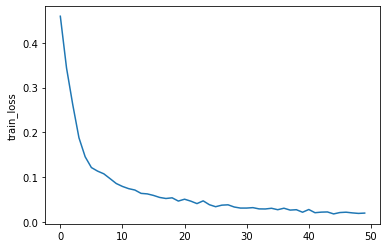

In [21]:
# plot loss curve
plt.figure()
plt.plot(range(len(loss_train)),loss_train)
plt.ylabel('train_loss')
plt.savefig('./save/fed_{}_{}_{}_C{}_iid.png'.format("Covid","mobileNet",epochs,frac))



In [24]:
# testing
net_glob.eval()
test_acc(net_glob, training_data)
test_acc(net_glob, test_data)

Got 25074 / 25182 with accuracy 99.57
Got 383 / 400 with accuracy 95.75
